Import Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import re

Load Data & Exploration

In [2]:
!pip -q install kaggle

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle datasets download -d equinxx/stock-tweets-for-sentiment-analysis-and-prediction -p /content/data

Dataset URL: https://www.kaggle.com/datasets/equinxx/stock-tweets-for-sentiment-analysis-and-prediction
License(s): CC0-1.0
  0% 0.00/6.59M [00:00<?, ?B/s]
100% 6.59M/6.59M [00:00<00:00, 859MB/s]


In [5]:
!unzip -o /content/data/*.zip -d /content/data

Archive:  /content/data/stock-tweets-for-sentiment-analysis-and-prediction.zip
  inflating: /content/data/stock_tweets.csv  
  inflating: /content/data/stock_yfinance_data.csv  


In [6]:
tweets_df = pd.read_csv("/content/data/stock_tweets.csv")
stocks_df = pd.read_csv("/content/data/stock_yfinance_data.csv")

In [7]:

import nltk
from nltk.tokenize import TreebankWordTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [8]:

try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')

tokenizer = TreebankWordTokenizer()
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [9]:
def clean_tweet(text):
    """Cleans tweet text using the reliable TreebankWordTokenizer."""
    text = re.sub(r'http\S+|@\w+|\$\w+|#\w+', '', text)
    text = re.sub(r'[^\w\s]', '', text.lower())
    tokens = [
        lemmatizer.lemmatize(word)
        for word in tokenizer.tokenize(text)
        if word not in stop_words and word.isalpha()
    ]
    return ' '.join(tokens)

tweets_df['cleaned_tweet'] = tweets_df['Tweet'].apply(clean_tweet)
print("Tweet text cleaned.")

Tweet text cleaned.


In [10]:

tweets_df['Date'] = pd.to_datetime(tweets_df['Date'], utc=True)
stocks_df['Date'] = pd.to_datetime(stocks_df['Date'])
tweets_df['Date_only'] = tweets_df['Date'].dt.date
stocks_df['Date_only'] = stocks_df['Date'].dt.date
print("Date formats standardized.")

Date formats standardized.


In [12]:
print("\nChecking for null values in the original datasets:")
print("\nNull values in tweets_df:")
print(tweets_df.isnull().sum())
print("\nNull values in stocks_df:")
print(stocks_df.isnull().sum())


Checking for null values in the original datasets:

Null values in tweets_df:
Date             0
Tweet            0
Stock Name       0
Company Name     0
cleaned_tweet    0
Date_only        0
dtype: int64

Null values in stocks_df:
Date          0
Open          0
High          0
Low           0
Close         0
Adj Close     0
Volume        0
Stock Name    0
Date_only     0
dtype: int64


In [14]:
import seaborn as sns
sns.set_style('whitegrid')

In [16]:
import matplotlib.pyplot as plt

/tmp/ipython-input-402128331.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=tweets_df['Stock Name'], order=tweets_df['Stock Name'].value_counts().index, palette='viridis')


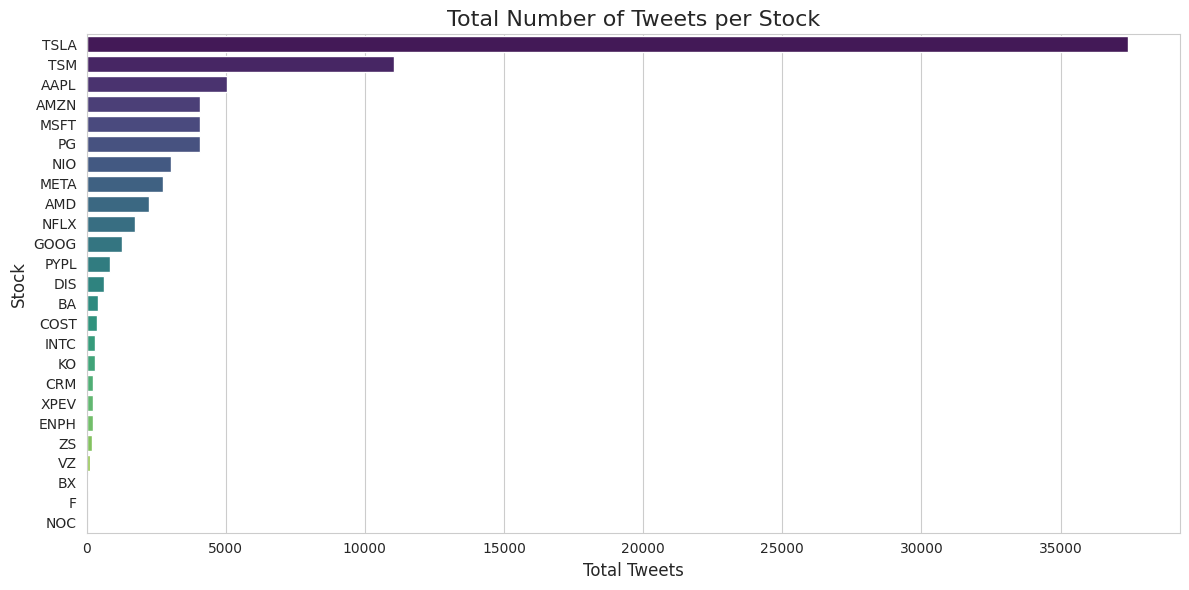

In [17]:
plt.figure(figsize=(12, 6))
sns.countplot(y=tweets_df['Stock Name'], order=tweets_df['Stock Name'].value_counts().index, palette='viridis')
plt.title('Total Number of Tweets per Stock', fontsize=16)
plt.xlabel('Total Tweets', fontsize=12)
plt.ylabel('Stock', fontsize=12)
plt.tight_layout()
plt.show()

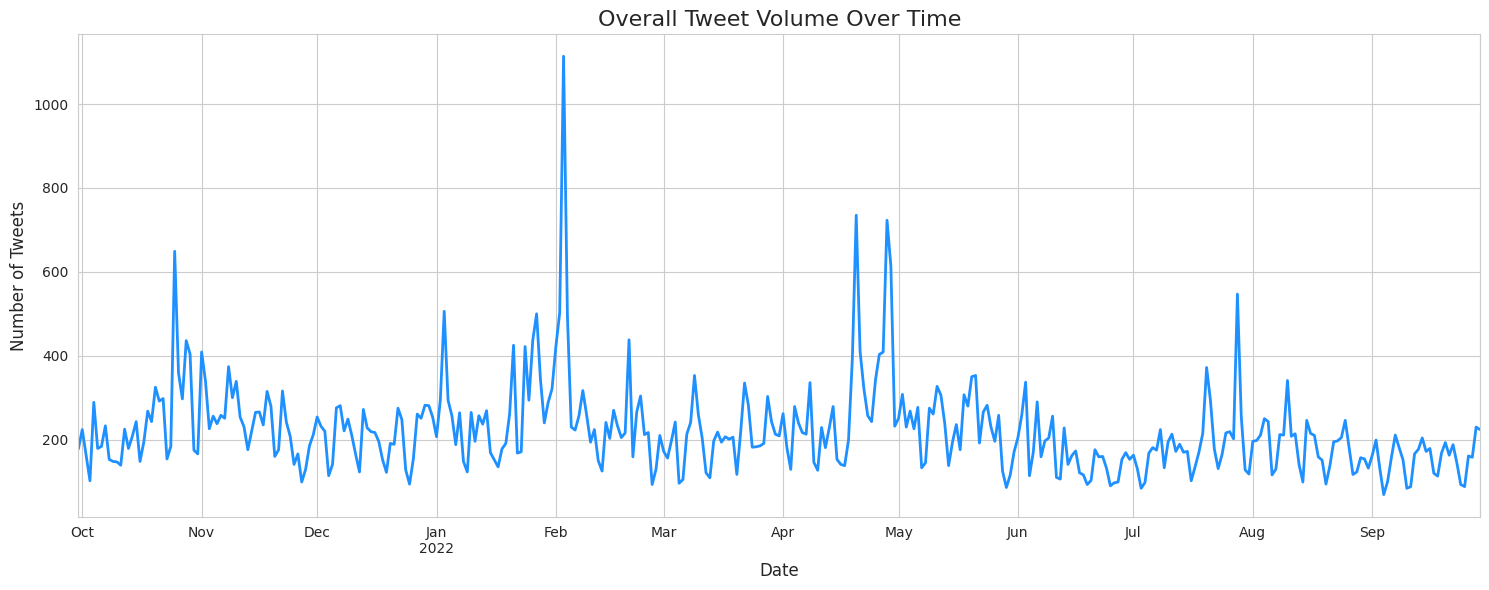

In [18]:
daily_tweet_counts = tweets_df.groupby(pd.to_datetime(tweets_df['Date_only'])).size()
plt.figure(figsize=(15, 6))
daily_tweet_counts.plot(kind='line', color='dodgerblue', lw=2)
plt.title('Overall Tweet Volume Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Tweets', fontsize=12)
plt.tight_layout()
plt.show()

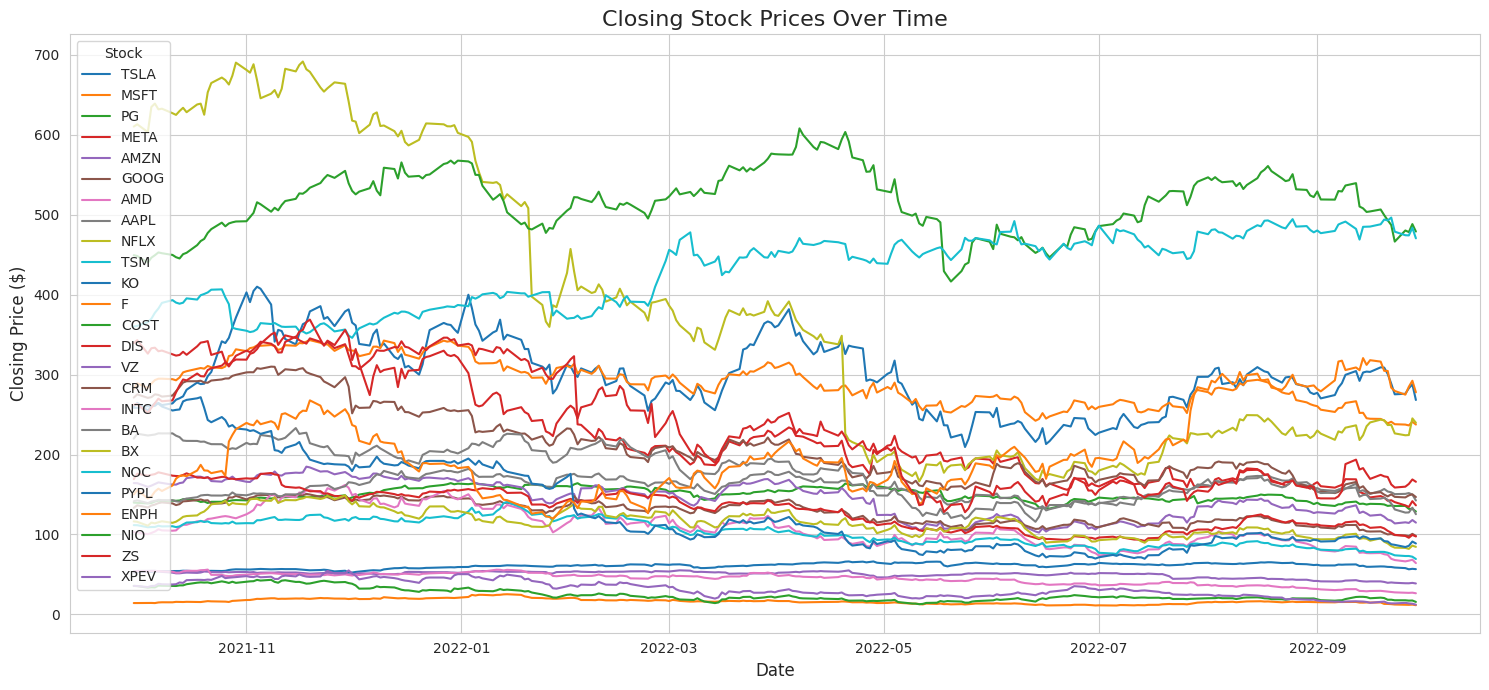

In [19]:
plt.figure(figsize=(15, 7))
sns.lineplot(data=stocks_df, x='Date', y='Close', hue='Stock Name', palette='tab10')
plt.title('Closing Stock Prices Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Closing Price ($)', fontsize=12)
plt.legend(title='Stock')
plt.tight_layout()
plt.show()

 Sentiment Analysis

In [20]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.auto import tqdm

MODEL_NAME = "yiyanghkust/finbert-tone"
finbert_tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
finbert_model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
finbert_model.to(device)
finbert_model.eval()
print(f"FinBERT model loaded on device: {device}")

FinBERT model loaded on device: cuda


In [21]:
def get_finbert_scores(text):
    inputs = finbert_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        logits = finbert_model(**inputs).logits
    probs = torch.softmax(logits, dim=-1).cpu().numpy().squeeze()
    return {'positive': float(probs[0]), 'negative': float(probs[1]), 'neutral': float(probs[2])}

In [22]:
tqdm.pandas(desc="Analyzing Tweet Sentiment")
sentiment_scores = tweets_df['cleaned_tweet'].progress_map(get_finbert_scores)
scores_df = pd.DataFrame(sentiment_scores.tolist())
tweets_df = pd.concat([tweets_df, scores_df], axis=1)
print("Sentiment analysis complete.")

Analyzing Tweet Sentiment:   0%|          | 0/80793 [00:00<?, ?it/s]

Sentiment analysis complete.


Data Fusion and Feature Engineering

In [27]:
daily_scores_df = tweets_df.groupby(['Date_only', 'Stock Name']).agg({
    'positive': 'sum', 'negative': 'sum', 'neutral': 'sum'
}).reset_index()
daily_tweet_counts = tweets_df.groupby(['Date_only', 'Stock Name']).size().reset_index(name='tweet_count')
daily_scores_df = pd.merge(daily_scores_df, daily_tweet_counts, on=['Date_only', 'Stock Name'])
print("Daily sentiment scores aggregated.")

Daily sentiment scores aggregated.


In [28]:
df_merged = pd.merge(stocks_df, daily_scores_df, on=['Date_only', 'Stock Name'], how='left')

In [29]:
print("\nChecking for null values after merging (before filling):")
print(df_merged.isnull().sum())


Checking for null values after merging (before filling):
Date              0
Open              0
High              0
Low               0
Close             0
Adj Close         0
Volume            0
Stock Name        0
Date_only         0
positive       2116
negative       2116
neutral        2116
tweet_count    2116
dtype: int64


In [31]:
sentiment_cols = ['positive', 'negative', 'neutral', 'tweet_count']
for col in sentiment_cols:
    df_merged[col] = df_merged[col].fillna(0)
df_merged = df_merged.sort_values(by=['Stock Name', 'Date']).reset_index(drop=True)
print("\nSentiment and stock data merged, and null values handled.")


Sentiment and stock data merged, and null values handled.


Model Preparation and Training

In [32]:
from sklearn.preprocessing import RobustScaler
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, GRU, Concatenate, Lambda
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

In [33]:
sequence_length = 20
feature_cols = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'positive', 'negative', 'neutral', 'tweet_count']

feature_scalers = {}
for col in feature_cols:
    scaler = RobustScaler()
    df_merged[col] = scaler.fit_transform(df_merged[[col]])
    feature_scalers[col] = scaler
df_merged['raw_Close'] = feature_scalers['Close'].inverse_transform(df_merged[['Close']])

X_list, y_list = [], []
for stock, group in df_merged.groupby('Stock Name'):
    features = group[feature_cols].values
    targets = group['raw_Close'].values
    for i in range(len(group) - sequence_length):
        X_list.append(features[i:i + sequence_length])
        y_list.append(targets[i + sequence_length])

X_all = np.array(X_list)
y_all = np.array(y_list).reshape(-1, 1)

y_scaler = RobustScaler()
y_all_scaled = y_scaler.fit_transform(y_all)
print("Data scaled and windowed sequences created.")

Data scaled and windowed sequences created.


In [34]:
split = int(0.8 * len(X_all))
X_train, y_train_scaled = X_all[:split], y_all_scaled[:split]
X_test, y_test_scaled, y_test_raw = X_all[split:], y_all_scaled[split:], y_all[split:]

val_split = int(0.2 * len(X_train))
X_val, y_val_scaled = X_train[-val_split:], y_train_scaled[-val_split:]
X_train_final, y_train_final_scaled = X_train[:-val_split], y_train_scaled[:-val_split]

batch_size = 32
train_ds = tf.data.Dataset.from_tensor_slices((X_train_final, y_train_final_scaled)).shuffle(10000).batch(batch_size, drop_remainder=True)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val_scaled)).batch(batch_size, drop_remainder=True)
print("Data split into training, validation, and test sets.")

Data split into training, validation, and test sets.


In [35]:
input_shape = (X_train.shape[1], X_train.shape[2])
inp = Input(shape=input_shape)
long_term = LSTM(128, return_sequences=True)(inp)
long_term = LSTM(64)(long_term)
short_term = Lambda(lambda x: x[:, -5:, :])(inp)
short_term = GRU(64)(short_term)
merged = Concatenate()([long_term, short_term])
dense_1 = Dense(32, activation='selu')(merged)
output = Dense(1)(dense_1)
model = Model(inp, output)

model.compile(optimizer=Adam(learning_rate=5e-4), loss=Huber(), metrics=['mae'])
print("Model built and compiled.")
model.summary()

Model built and compiled.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 20, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 20, 128)   │     71,168 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 5, 10)     │          0 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 64)        │     49,408 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru (GRU)           │ (None, 64)        │     14,592 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ gru[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │      4,128 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         33 │ dense[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 139,329 (544.25 KB)

 Trainable params: 139,329 (544.25 KB)

 Non-trainable params: 0 (0.00 B)

In [36]:
early_stop = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)
print("Starting model training...")
history = model.fit(train_ds, validation_data=val_ds, epochs=100, callbacks=[early_stop], verbose=1)
print("Model training complete.")

Starting model training...
Epoch 1/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step - loss: 0.0576 - mae: 0.2085 - val_loss: 0.0081 - val_mae: 0.0982
Epoch 2/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0028 - mae: 0.0508 - val_loss: 0.0040 - val_mae: 0.0639
Epoch 3/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0022 - mae: 0.0446 - val_loss: 0.0036 - val_mae: 0.0612
Epoch 4/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0020 - mae: 0.0436 - val_loss: 0.0021 - val_mae: 0.0439
Epoch 5/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0019 - mae: 0.0414 - val_loss: 0.0028 - val_mae: 0.0494
Epoch 6/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014 - mae: 0.0376 - val_loss: 0.0042 - val_mae: 0.0618
Epoch 7/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0018 - mae: 0.0421 - val_loss: 0.0022 - val_mae: 0.0438
Epoch 8/100
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0015 - mae: 0.0382 - val_loss: 0.0027 - val_mae: 0.0510
Epoch 9/100
116/11

Evaluation and Visualization

In [37]:
from sklearn.metrics import mean_absolute_error, r2_score

y_pred_scaled = model.predict(X_test)
y_pred_raw = y_scaler.inverse_transform(y_pred_scaled).flatten()
y_test_raw = y_test_raw.flatten()

mae = mean_absolute_error(y_test_raw, y_pred_raw)
r2 = r2_score(y_test_raw, y_pred_raw)
mape = np.mean(np.abs((y_test_raw - y_pred_raw) / np.where(y_test_raw == 0, 1, y_test_raw))) * 100

print("--- Model Evaluation on Test Data ---")
print(f"Mean Absolute Error (MAE): ${mae:.2f}")
print(f"R-squared (R²): {r2:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step
--- Model Evaluation on Test Data ---
Mean Absolute Error (MAE): $13.77
R-squared (R²): 0.94
Mean Absolute Percentage Error (MAPE): 7.49%


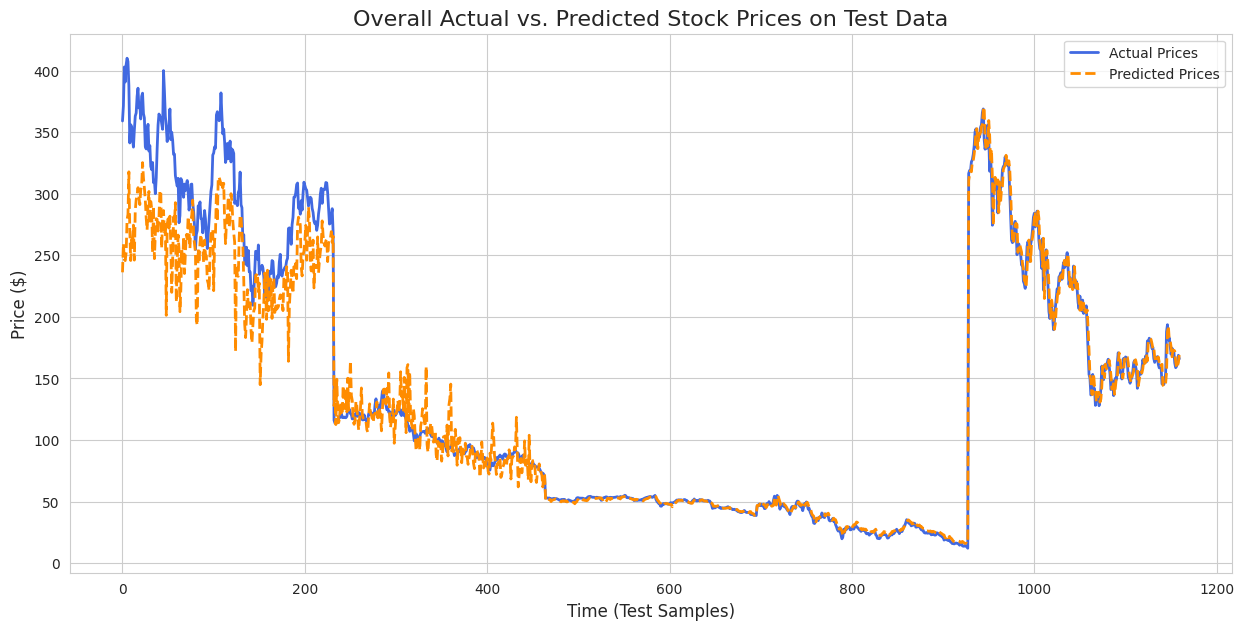

In [40]:
plt.figure(figsize=(15, 7))
plt.plot(y_test_raw, label='Actual Prices', color='royalblue', lw=2)
plt.plot(y_pred_raw, label='Predicted Prices', color='darkorange', lw=2, linestyle='--')
plt.title('Overall Actual vs. Predicted Stock Prices on Test Data', fontsize=16)
plt.xlabel('Time (Test Samples)', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend()
plt.grid(True)
plt.show()


--- Per-Stock Performance Evaluation ---


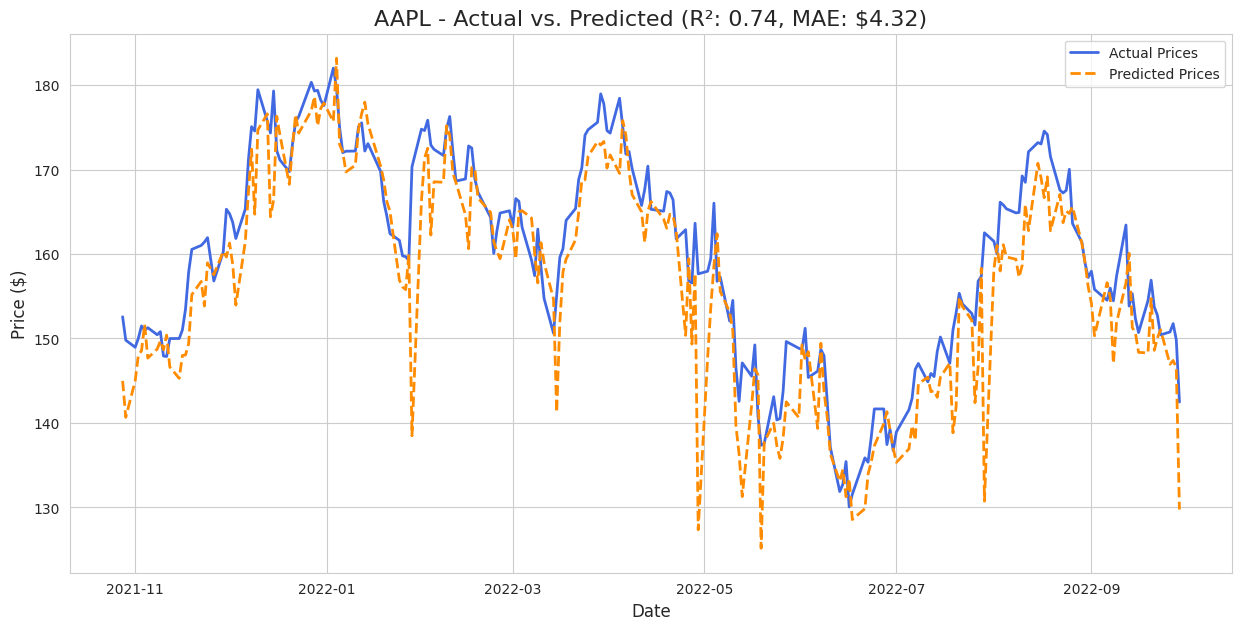

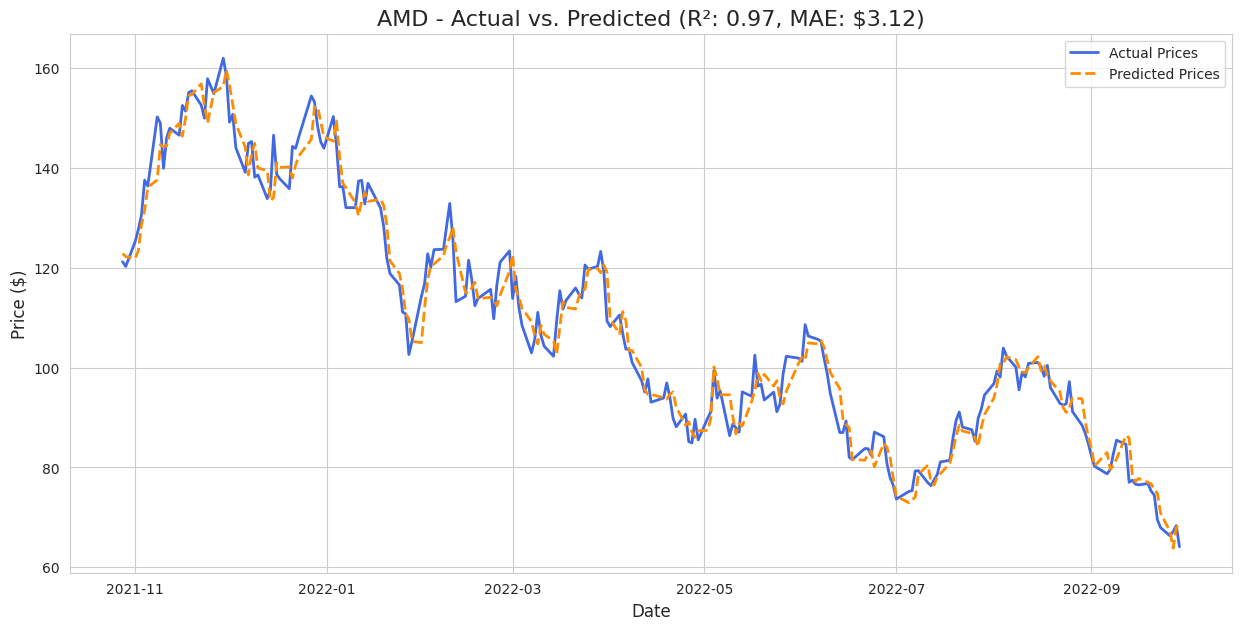

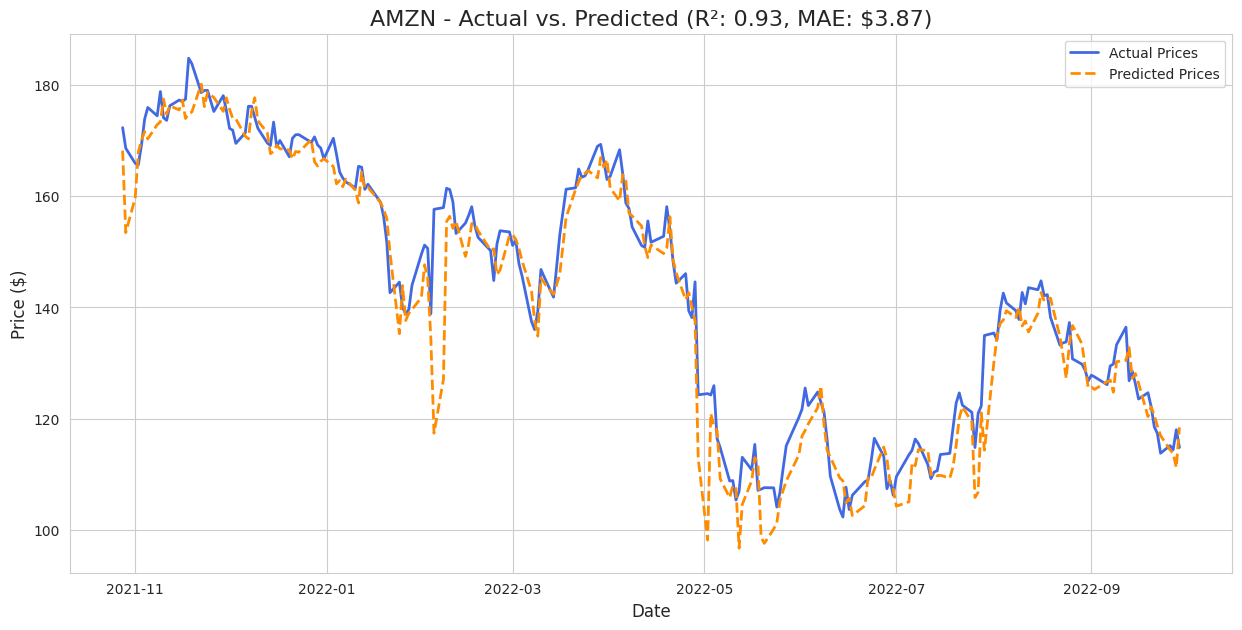

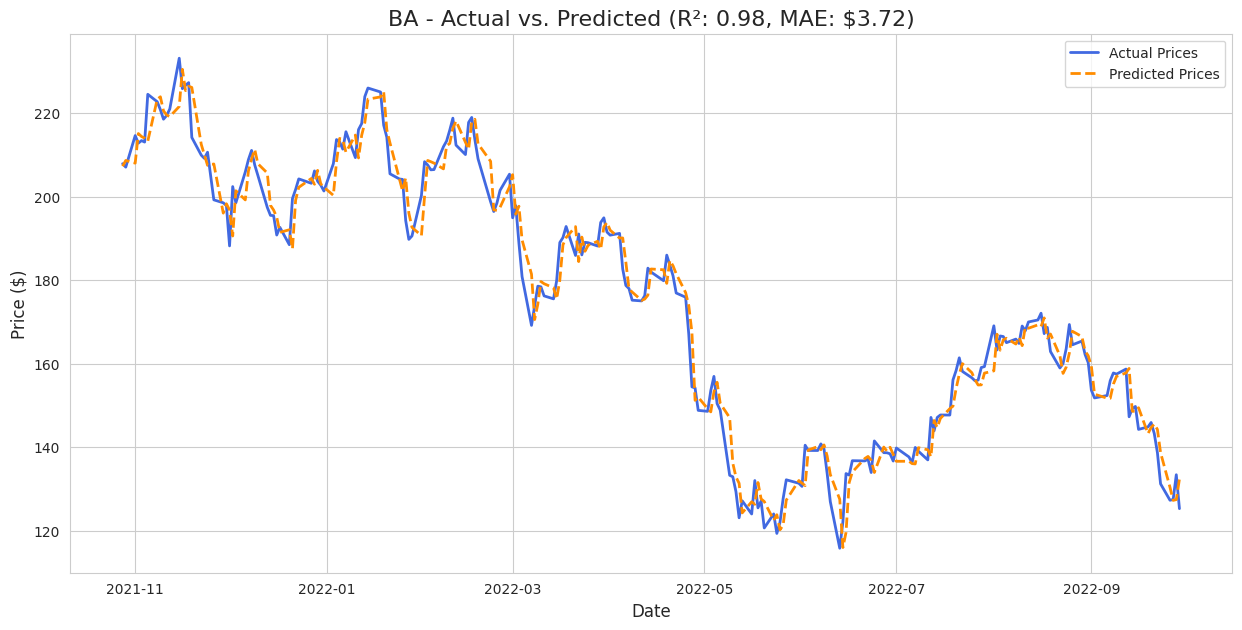

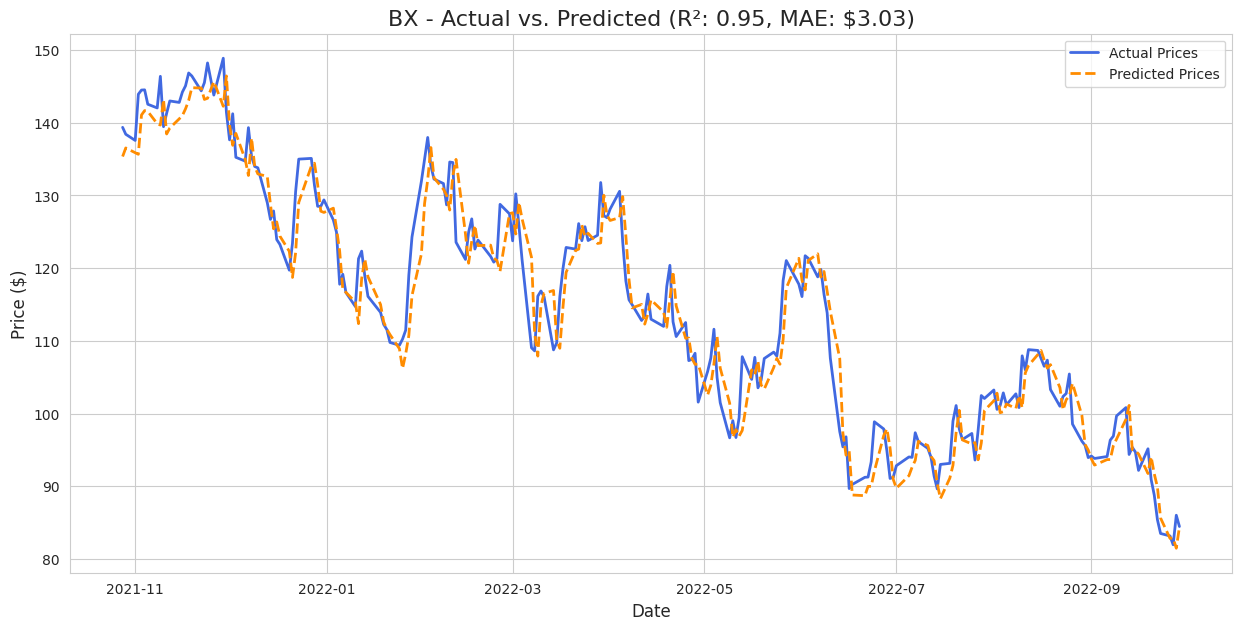

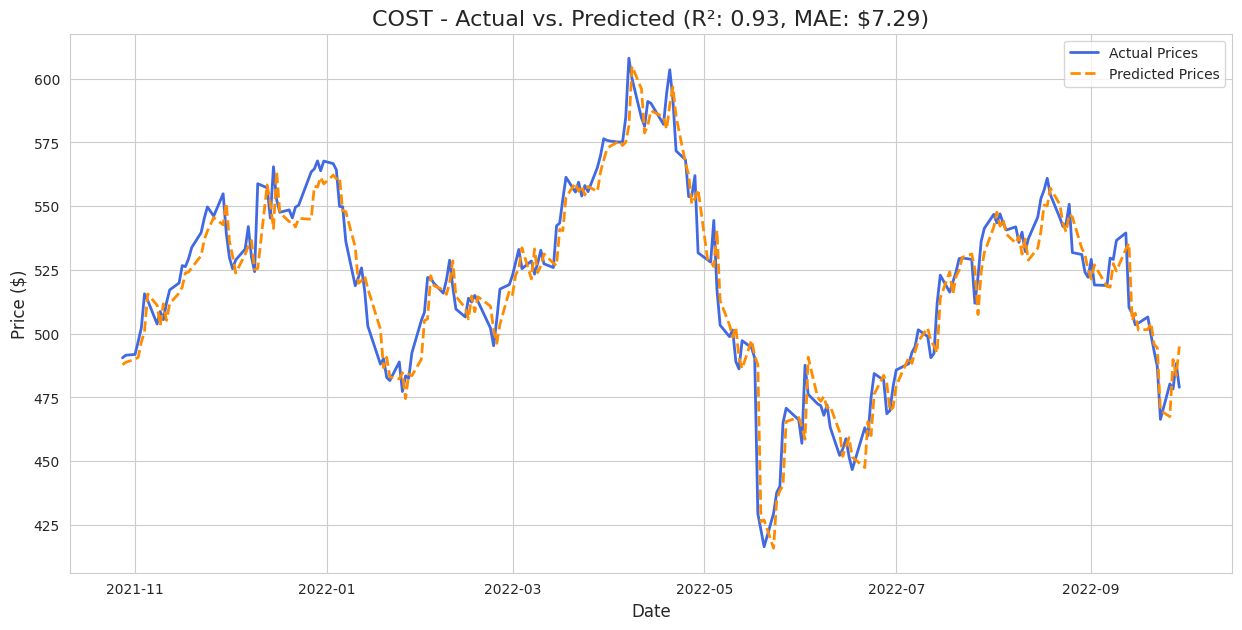

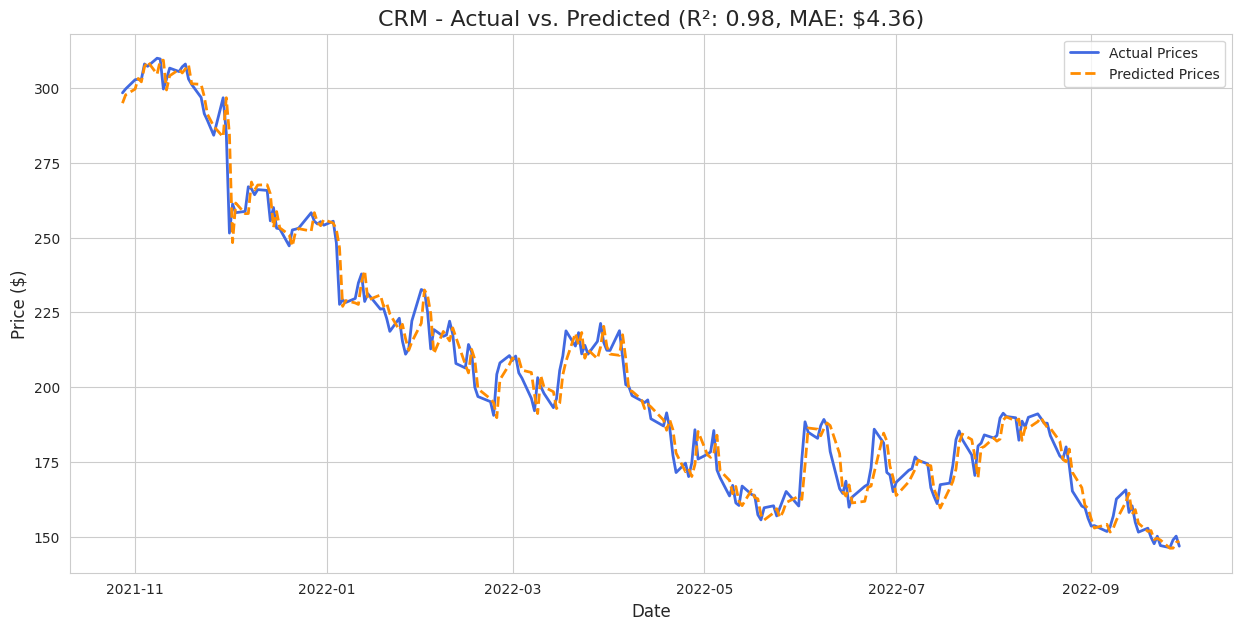

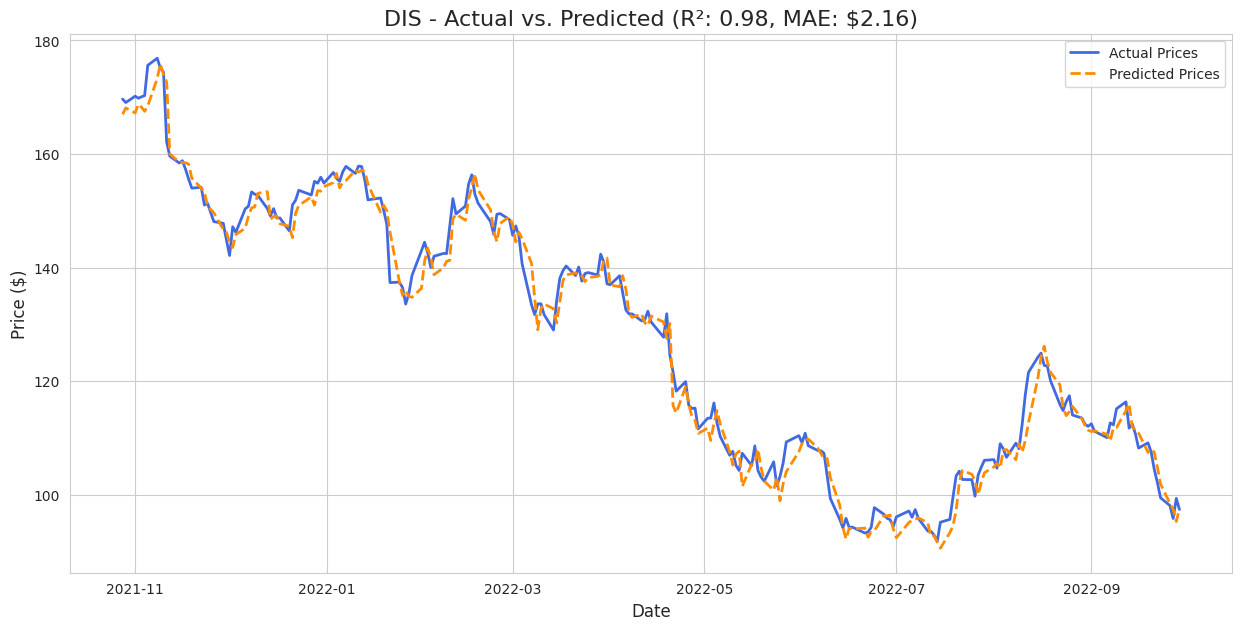

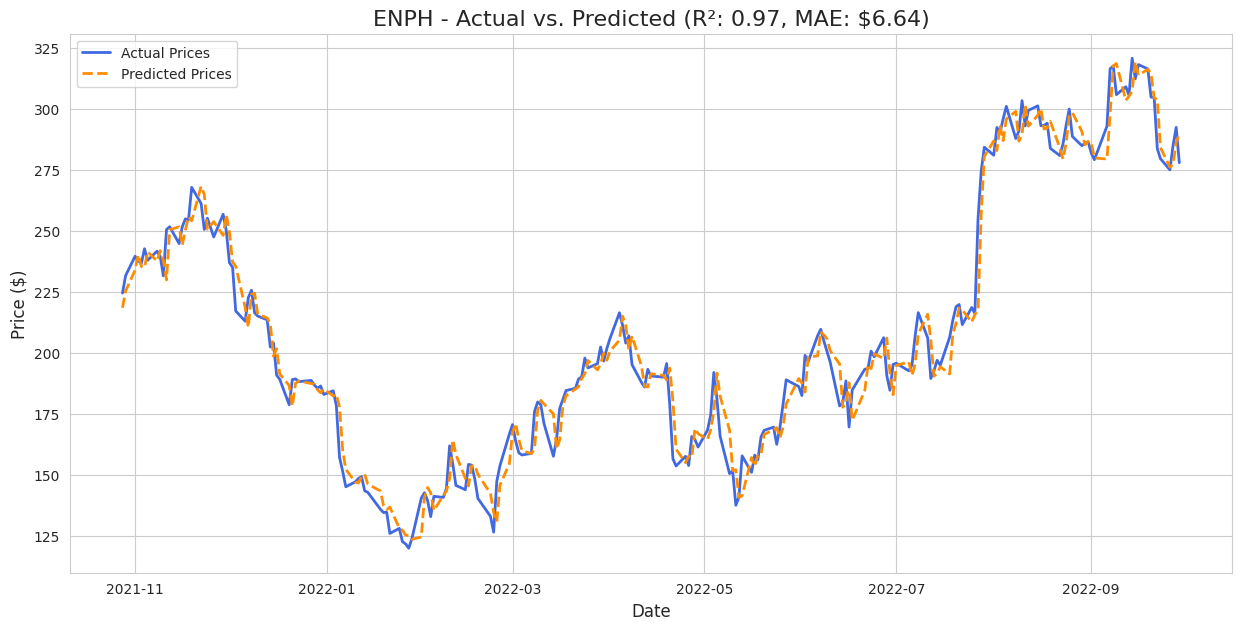

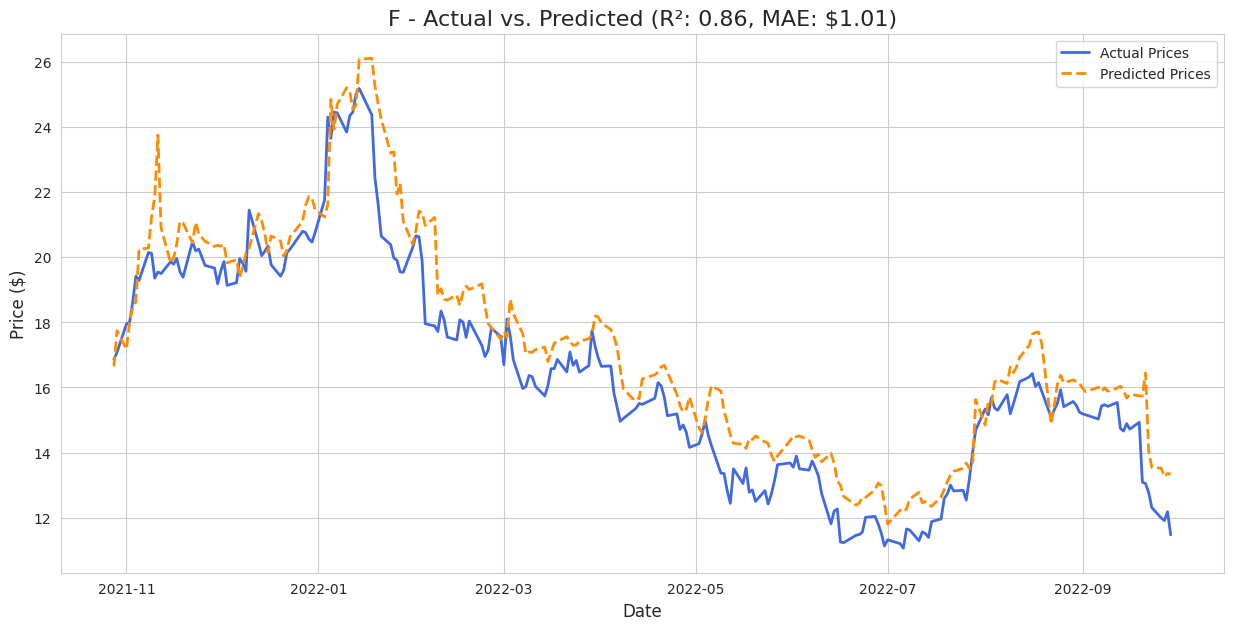

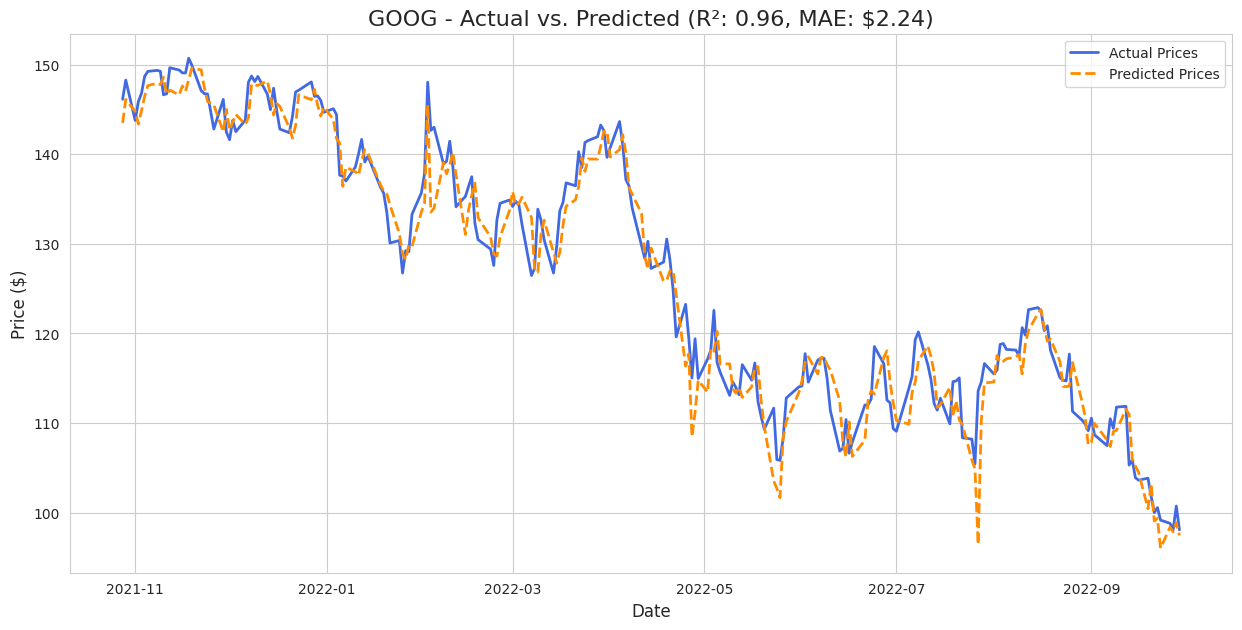

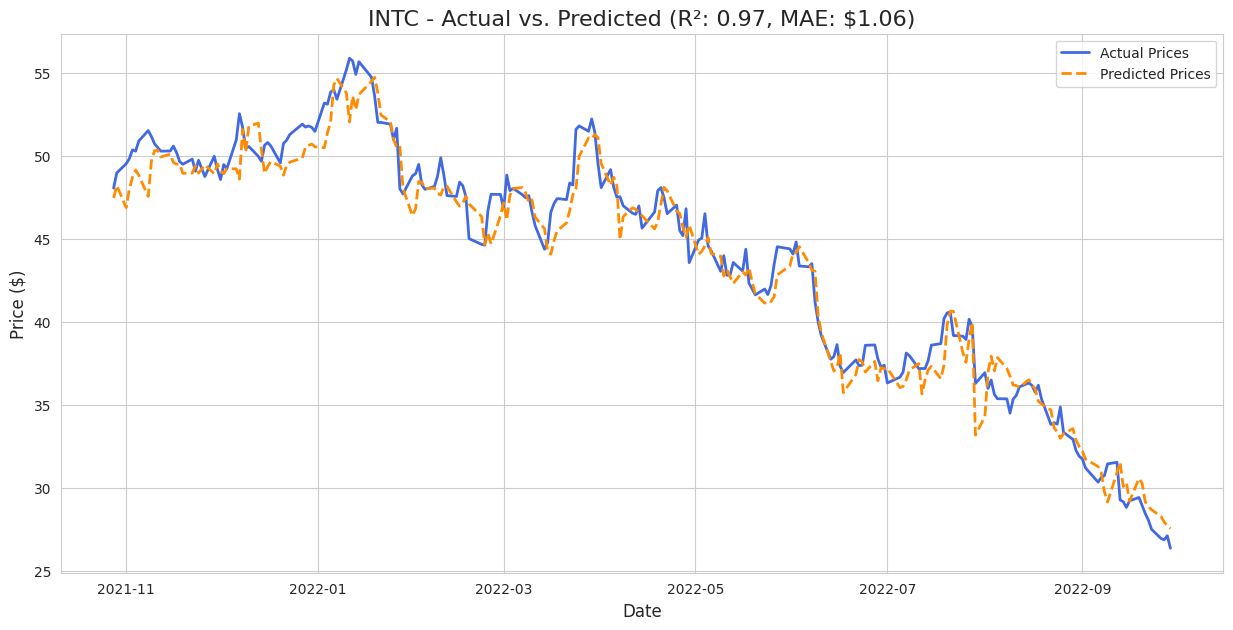

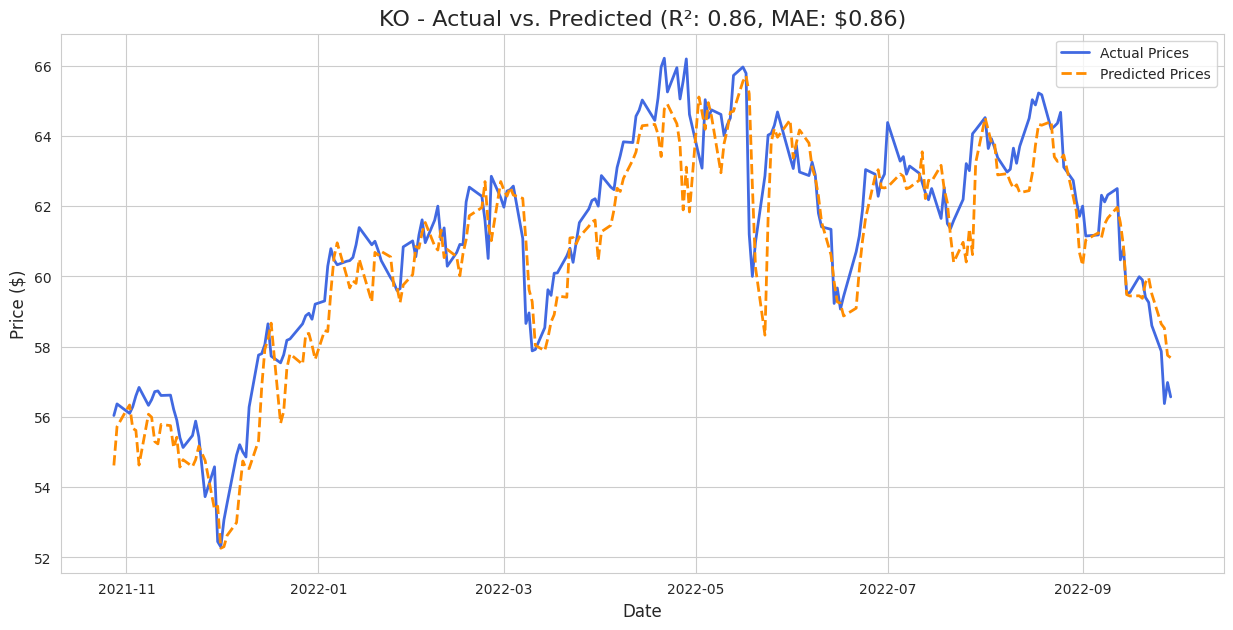

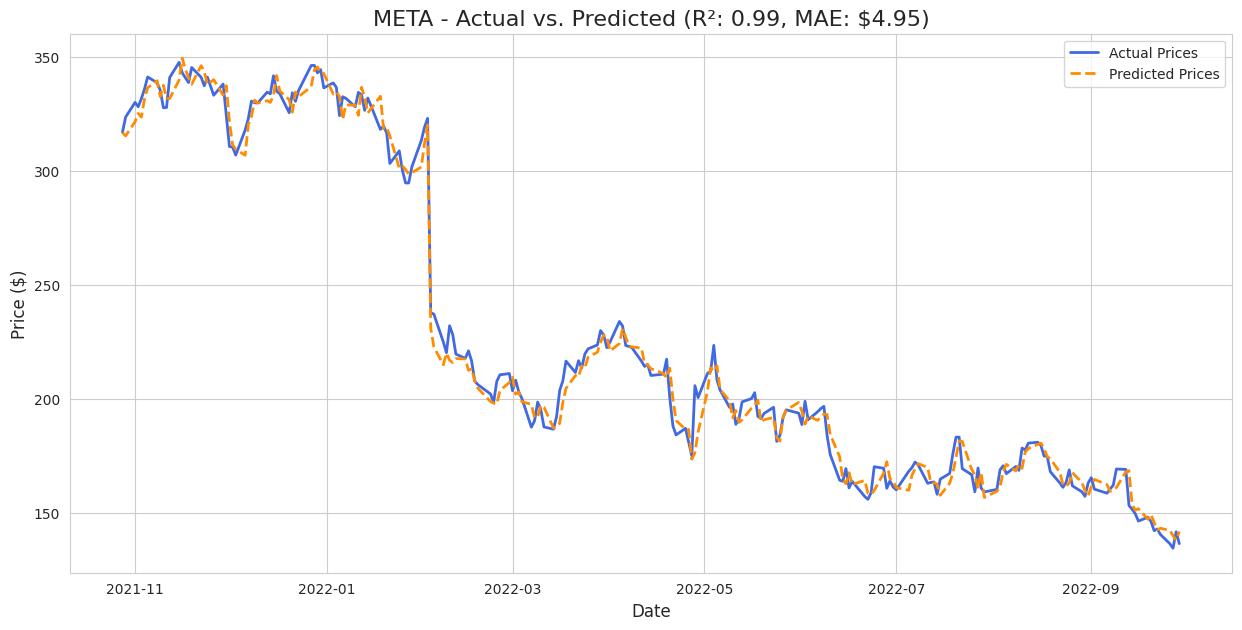

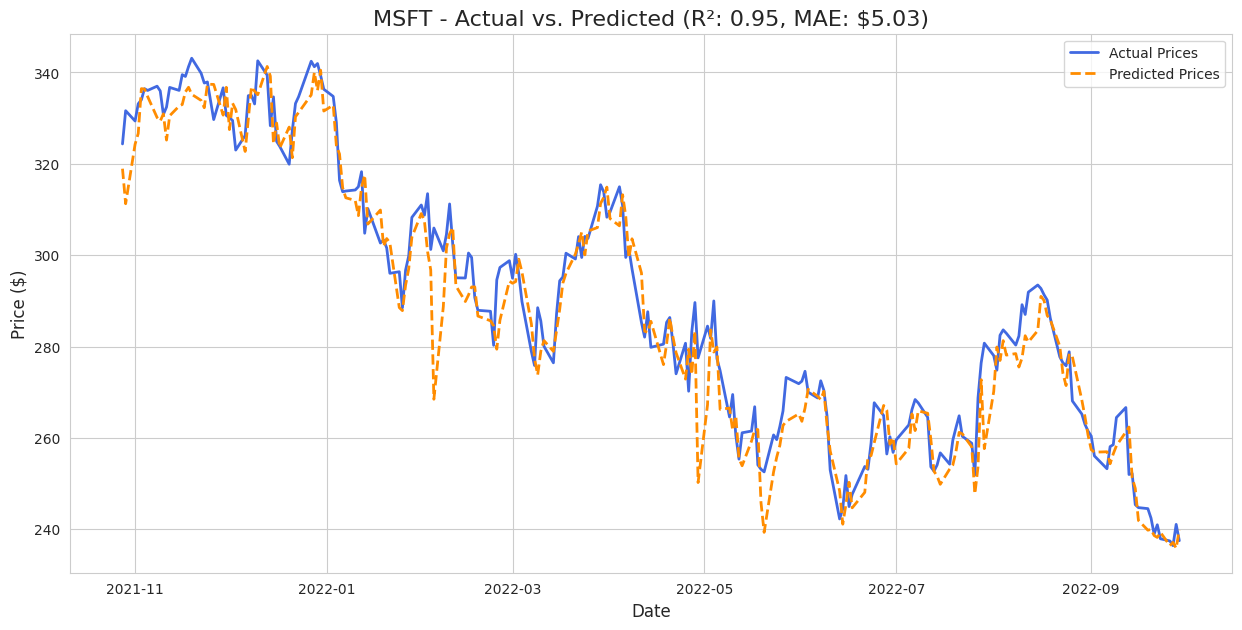

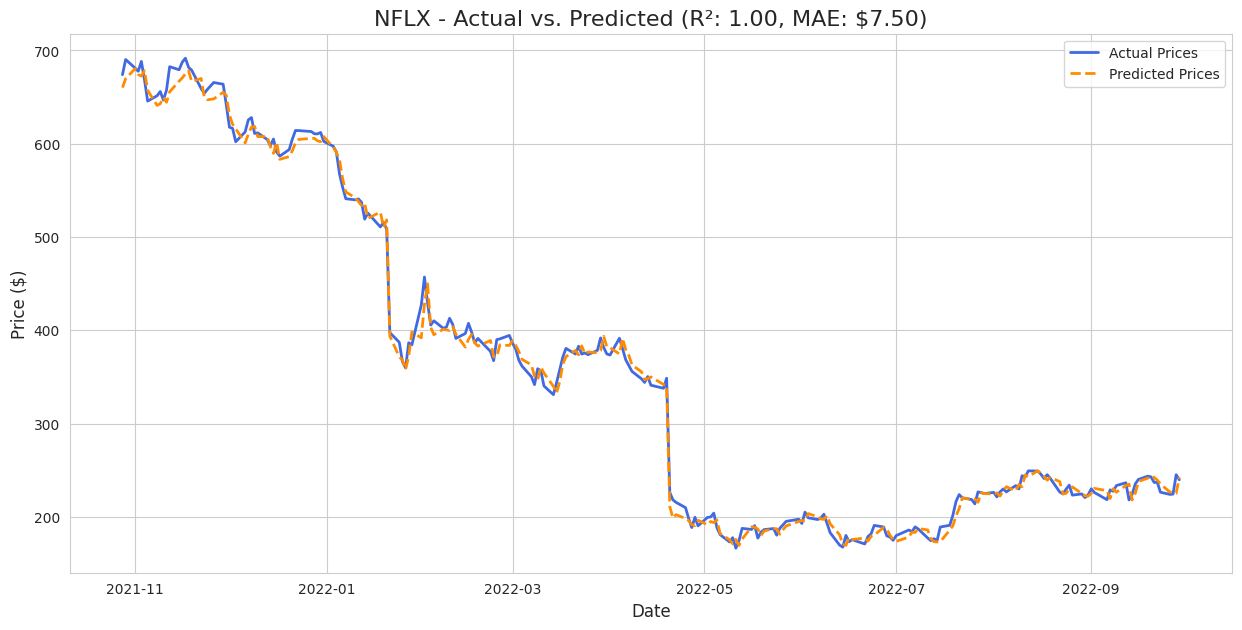

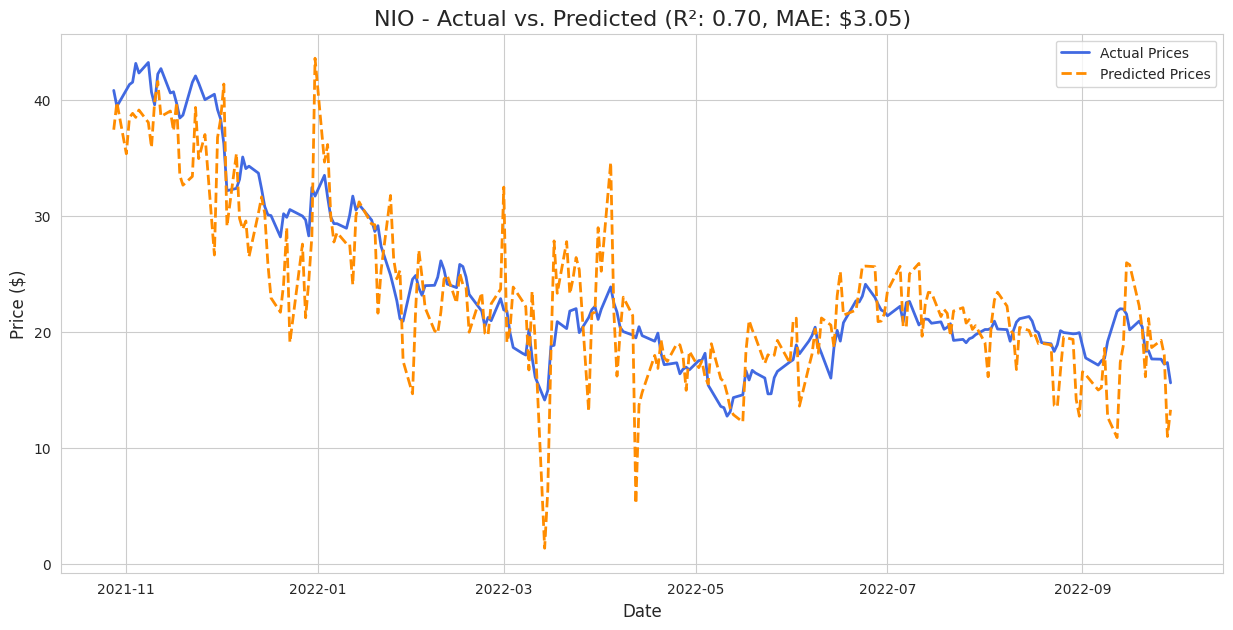

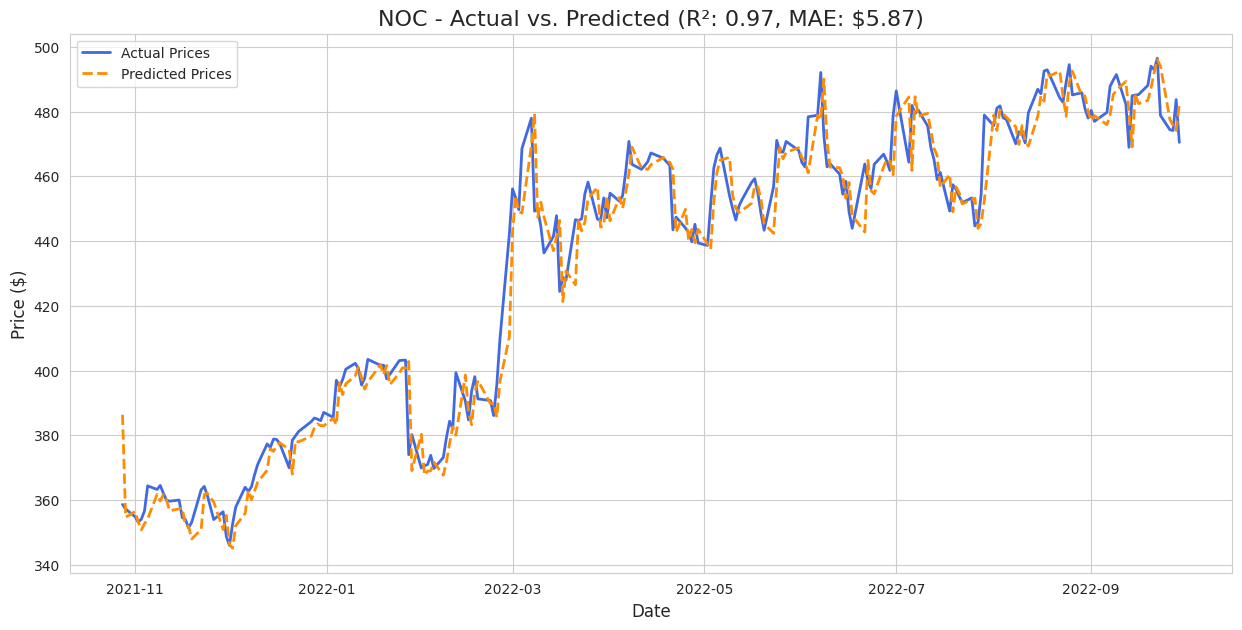

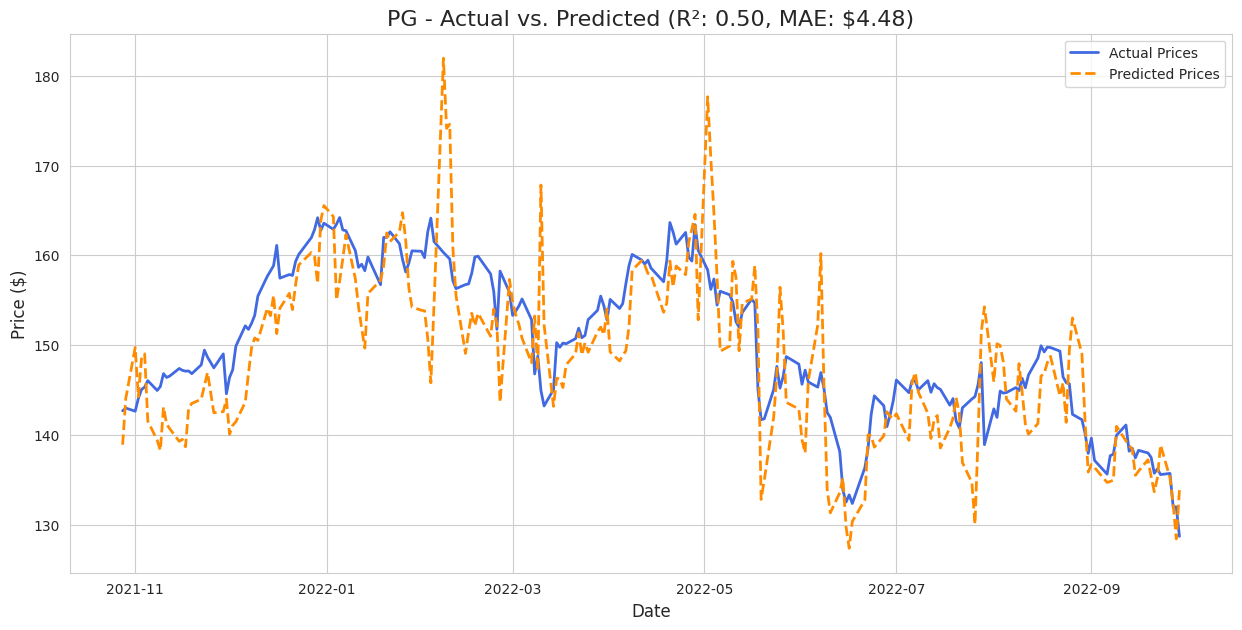

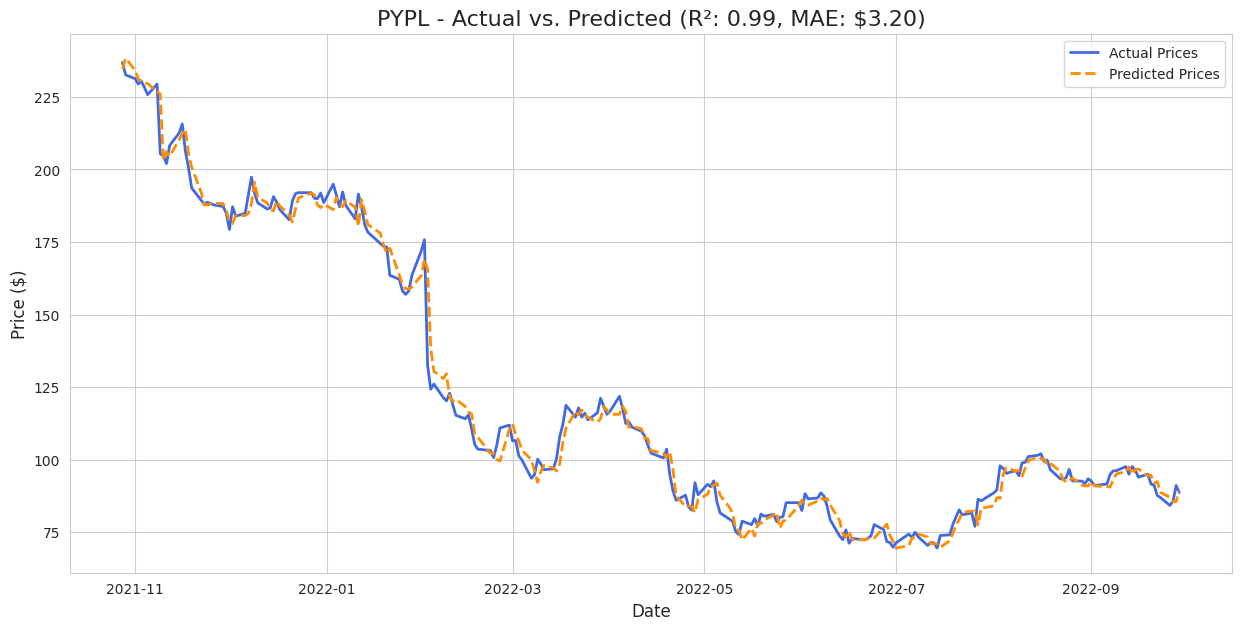

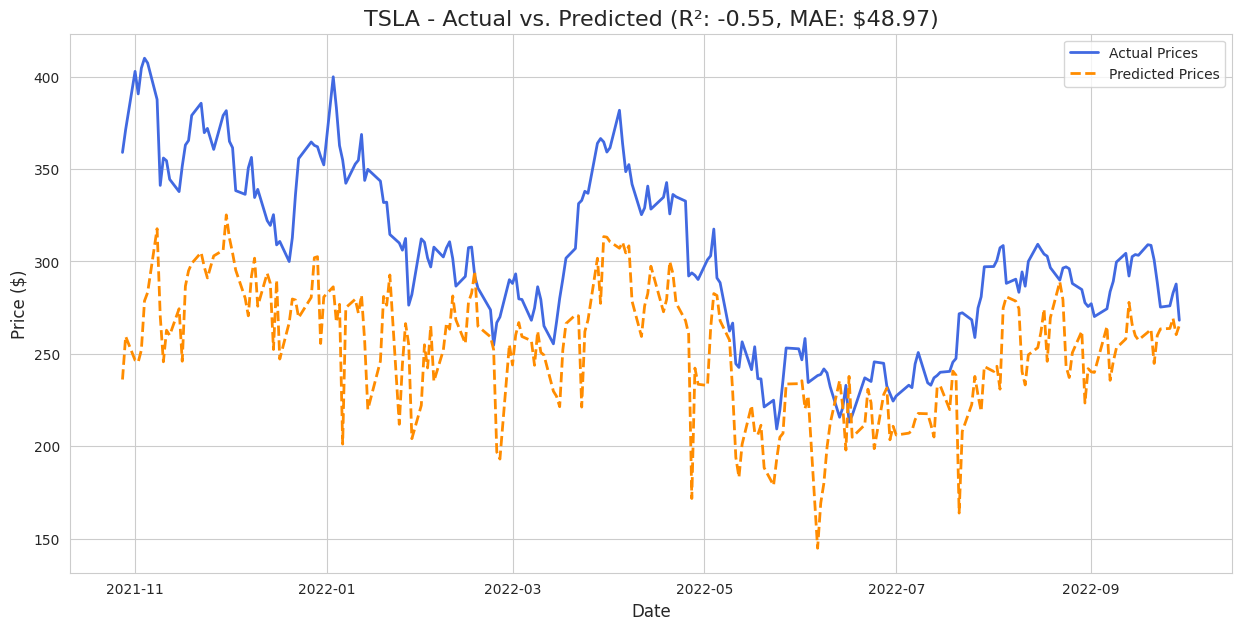

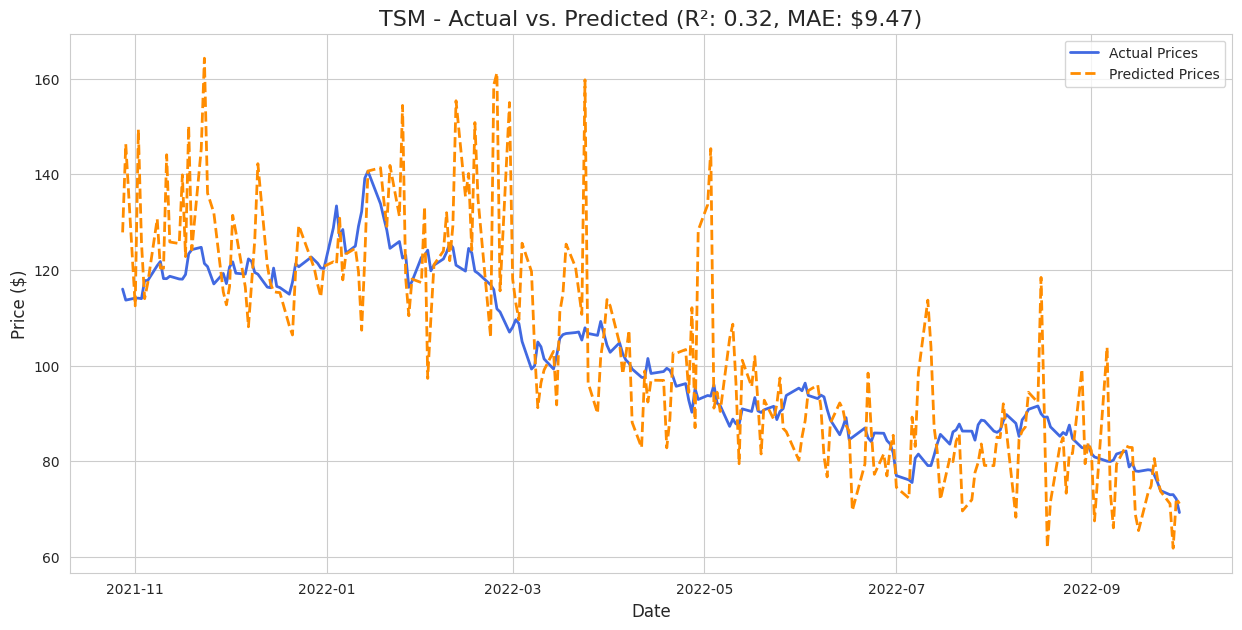

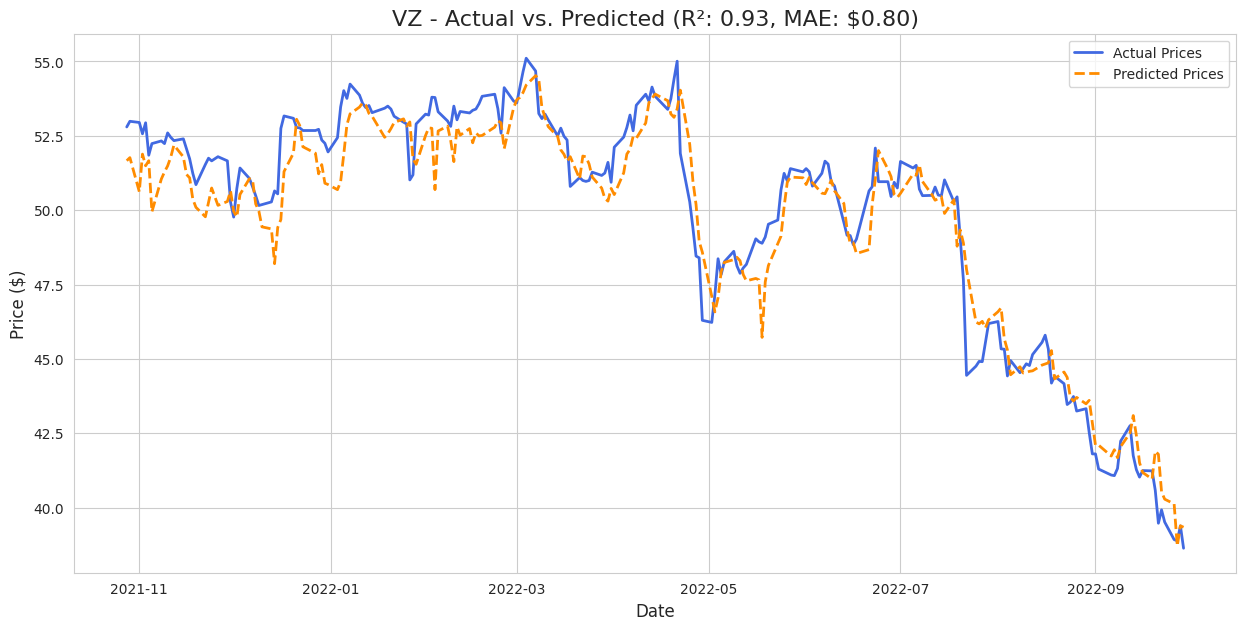

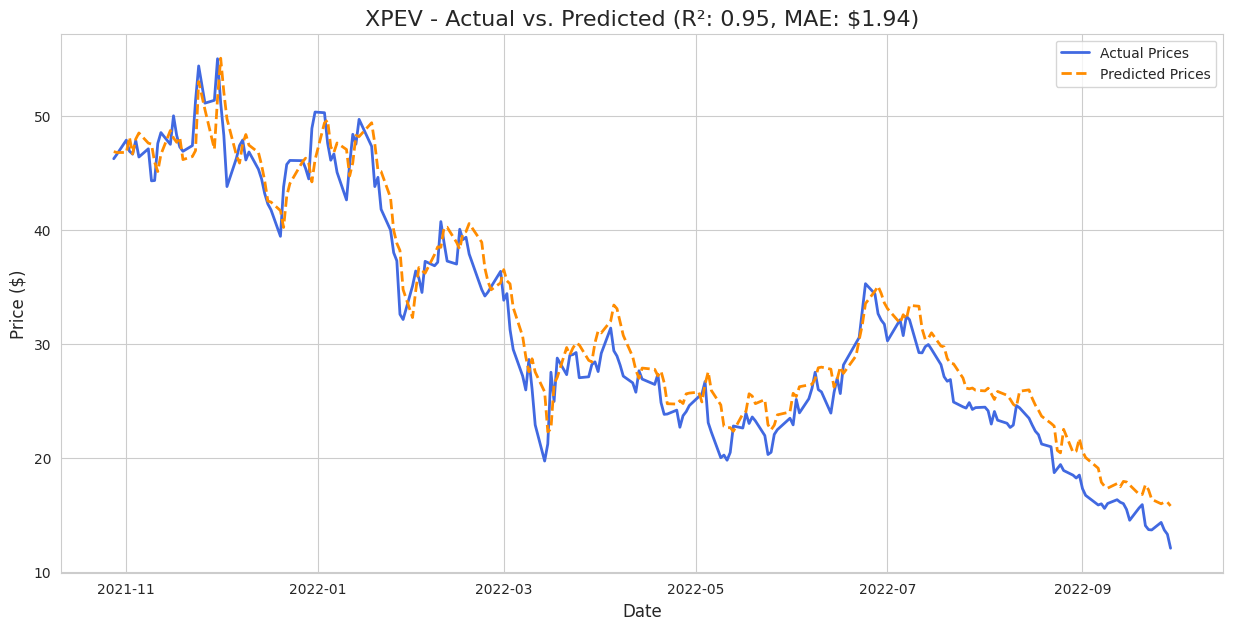

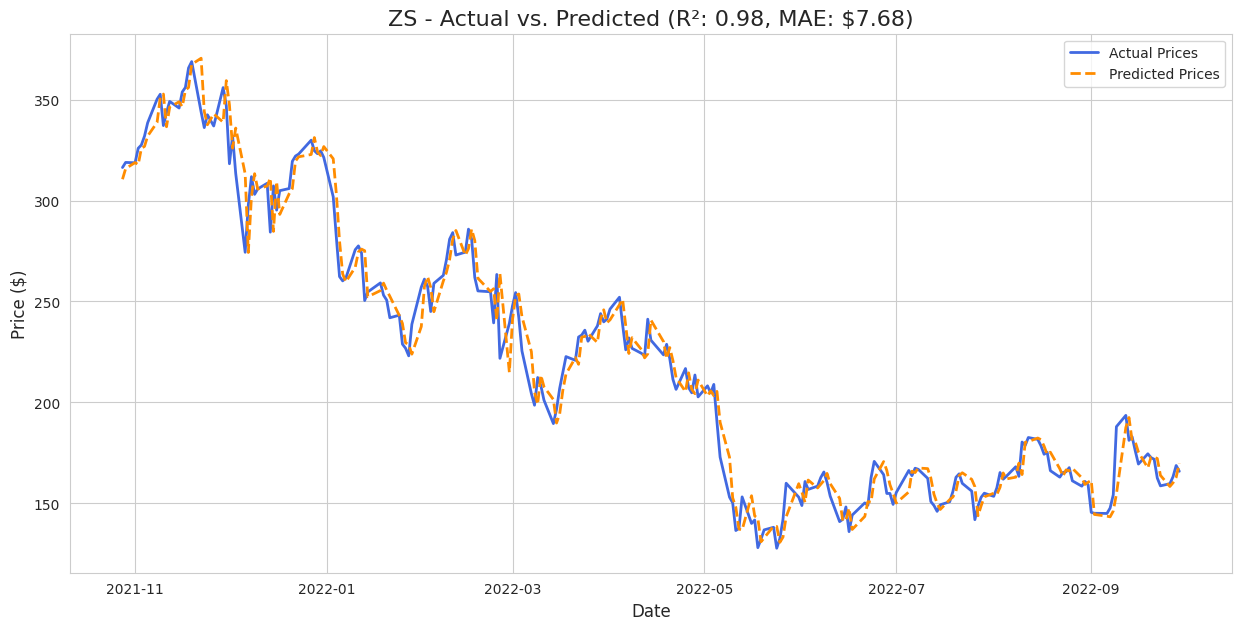

In [41]:
print("\n--- Per-Stock Performance Evaluation ---")
unique_stocks = df_merged['Stock Name'].unique()
for stock in unique_stocks:
    stock_df = df_merged[df_merged['Stock Name'] == stock].copy()
    X_stock, y_stock_raw = [], []
    features = stock_df[feature_cols].values
    targets = stock_df['raw_Close'].values
    for i in range(len(stock_df) - sequence_length):
        X_stock.append(features[i : i + sequence_length])
        y_stock_raw.append(targets[i + sequence_length])

    if len(X_stock) > 0:
        X_stock = np.array(X_stock)
        y_stock_raw = np.array(y_stock_raw).flatten()

        y_pred_scaled_stock = model.predict(X_stock, verbose=0)
        y_pred_raw_stock = y_scaler.inverse_transform(y_pred_scaled_stock).flatten()

        # Calculate metrics for this specific stock
        stock_mae = mean_absolute_error(y_stock_raw, y_pred_raw_stock)
        stock_r2 = r2_score(y_stock_raw, y_pred_raw_stock)

        dates = stock_df['Date'][sequence_length:]

        plt.figure(figsize=(15, 7))
        plt.plot(dates, y_stock_raw, label='Actual Prices', color='royalblue', lw=2)
        plt.plot(dates, y_pred_raw_stock, label='Predicted Prices', color='darkorange', lw=2, linestyle='--')

        # Add the metrics to the plot title
        plt.title(f'{stock} - Actual vs. Predicted (R²: {stock_r2:.2f}, MAE: ${stock_mae:.2f})', fontsize=16)

        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Price ($)', fontsize=12)
        plt.legend()
        plt.grid(True)

        # Save the plot to a file
        plt.savefig(f'{stock}_prediction_plot.png')
        plt.show()


In [43]:
import pickle

In [44]:
print("\nSaving model and scalers...")

os.makedirs('saved_model', exist_ok=True)
os.makedirs('scalers', exist_ok=True)

model.save('saved_model/stock_forecasting_model.h5')

with open('scalers/y_scaler.pkl', 'wb') as f:
    pickle.dump(y_scaler, f)

with open('scalers/feature_scalers.pkl', 'wb') as f:
    pickle.dump(feature_scalers, f)

print("Model and scalers saved successfully.")



Saving model and scalers...
Model and scalers saved successfully.
